In [9]:
# === Imports & display shim ===
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: datasets, model selection, preprocessing, pipelines, models, metrics
from sklearn.datasets import load_diabetes
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer

# SciPy helper for IQR (used in Silverman bandwidth)
from scipy.stats import iqr

# Statsmodels for OLS, diagnostics, QQ-plots
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot

# Display shim: replace caas_jupyter_tools.display_dataframe_to_user
try:
    from IPython.display import display
    def display_dataframe_to_user(title: str, df: pd.DataFrame):
        print(title)
        display(df)
except Exception:
    def display_dataframe_to_user(title: str, df: pd.DataFrame):
        print(title)
        print(df.to_string(index=False))


In [10]:
# === Load dataset and build DataFrame ===
# Load the diabetes dataset (features are standardized)
diabetes = load_diabetes()

# Convert to pandas structures for convenience
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name="target")

# Combine features and target in a single DataFrame for convenience
df = X.copy()
df["target"] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [11]:
# === KDE helpers (Gaussian kernel, bandwidth rules, LOO-CV) ===
def gaussian_kernel(u):
    """Standard normal pdf evaluated at u."""
    return (1.0 / np.sqrt(2*np.pi)) * np.exp(-0.5 * u**2)

def kde_gaussian(x_eval, data, h):
    """Univariate Gaussian KDE evaluated on x_eval given sample `data` and bandwidth h."""
    data = np.asarray(data)
    x_eval = np.asarray(x_eval)
    u = (x_eval[:, None] - data[None, :]) / h  # pairwise standardized distances
    return gaussian_kernel(u).sum(axis=1) / (len(data) * h)

def scott_bandwidth(data):
    """Scott's rule-of-thumb bandwidth."""
    data = np.asarray(data)
    n = data.shape[0]
    return np.std(data, ddof=1) * n ** (-1/5)

def silverman_bandwidth(data):
    """Silverman's rule-of-thumb bandwidth."""
    data = np.asarray(data)
    n = data.shape[0]
    s = np.std(data, ddof=1)
    a = min(s, iqr(data)/1.34)
    return 0.9 * a * n ** (-1/5)

def loo_log_likelihood(data, h):
    """Leave-one-out log-likelihood for KDE with bandwidth h."""
    data = np.asarray(data)
    n = data.shape[0]
    diffs = (data[:, None] - data[None, :]) / h
    K = (1.0 / np.sqrt(2*np.pi)) * np.exp(-0.5 * diffs**2)
    np.fill_diagonal(K, 0.0)                # zero self-kernel for LOO
    f_loo = K.sum(axis=1) / ((n-1) * h)     # LOO density estimates
    f_loo = np.clip(f_loo, 1e-12, None)     # avoid log(0)
    return np.log(f_loo).sum()

def select_bandwidth_grid(data, grid):
    """Grid search over bandwidths by maximizing LOO log-likelihood."""
    vals = [loo_log_likelihood(data, h) for h in grid]
    best_idx = int(np.argmax(vals))
    return grid[best_idx], pd.DataFrame({"h": grid, "loo_loglik": vals})


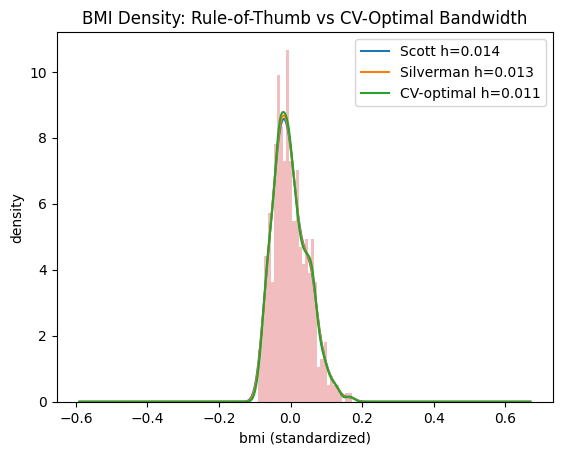

KDE bandwidth search (leave-one-out log-likelihood)


,h,loo_loglik
0,0.00253,707.239095
1,0.00276,711.468454
2,0.00301,715.071307
3,0.00327,718.027459
4,0.00356,720.635326
5,0.00388,722.898715
6,0.00423,724.838718
7,0.00460,726.448127
8,0.00501,727.847534
9,0.00546,729.045951


In [12]:
# === KDE on BMI (bandwidth selection and plot) ===
# Extract BMI as a numpy array and build an evaluation grid
bmi = df["bmi"].values
x_grid = np.linspace(bmi.min()-0.5, bmi.max()+0.5, 600)

# Rule-of-thumb bandwidths
h_scott = scott_bandwidth(bmi)
h_silv  = silverman_bandwidth(bmi)

# Log-spaced bandwidth grid (clipped away from zero), slight rounding for readability
grid = np.unique(np.round(np.geomspace(max(1e-3, h_silv/5), h_scott*5, 40), 5))

# LOO-CV optimal bandwidth
h_cv, cv_table = select_bandwidth_grid(bmi, grid)

# Plot density estimates for three bandwidths vs histogram
plt.figure()
for h, label in [(h_scott, f"Scott h={h_scott:.3f}"),
                 (h_silv,  f"Silverman h={h_silv:.3f}"),
                 (h_cv,    f"CV-optimal h={h_cv:.3f}")]:
    dens = kde_gaussian(x_grid, bmi, h)
    plt.plot(x_grid, dens, label=label)
plt.hist(bmi, bins=30, density=True, alpha=0.3)
plt.title("BMI Density: Rule-of-Thumb vs CV-Optimal Bandwidth")
plt.xlabel("bmi (standardized)")
plt.ylabel("density")
plt.legend()
plt.show()

# Show the bandwidth search table
display_dataframe_to_user("KDE bandwidth search (leave-one-out log-likelihood)",
                          cv_table.sort_values("h").reset_index(drop=True))


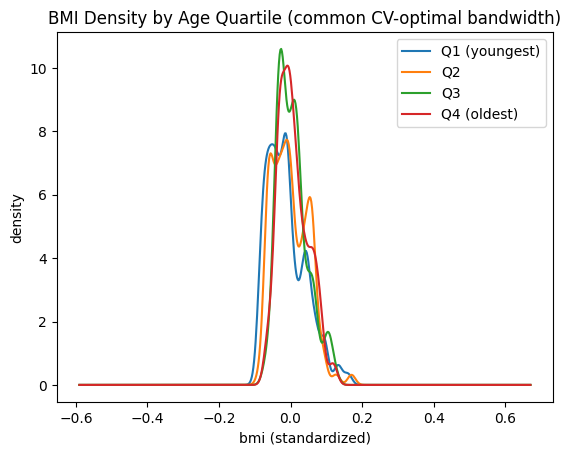

In [14]:
# === KDE by age quartiles with common bandwidth ===
# Split AGE into quartiles (labels are ordered)
age_q = pd.qcut(df["age"], 4, labels=["Q1 (youngest)", "Q2", "Q3", "Q4 (oldest)"])

# Plot group-wise densities using the same CV-optimal h for comparability
plt.figure()
for lab in age_q.cat.categories:
    d = df.loc[age_q == lab, "bmi"].values
    dens = kde_gaussian(x_grid, d, h_cv)
    plt.plot(x_grid, dens, label=str(lab))
plt.title("BMI Density by Age Quartile (common CV-optimal bandwidth)")
plt.xlabel("bmi (standardized)")
plt.ylabel("density")
plt.legend()
plt.show()


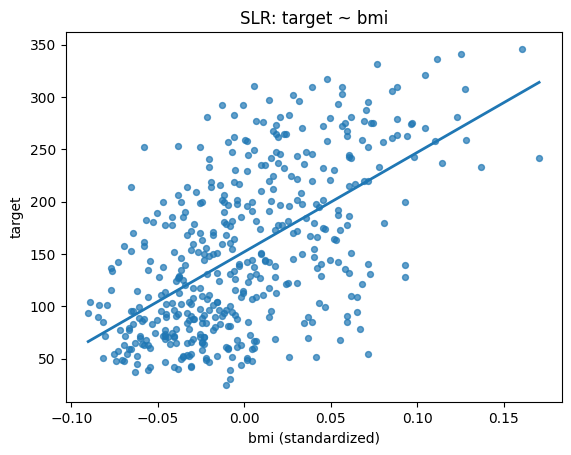

SLR summary


,metric,value
0,slope(bmi),949.435260
1,intercept,152.133484
2,RMSE,62.373525


In [15]:
# === Simple Linear Regression (SLR) target ~ bmi ===
# Prepare arrays for sklearn/statsmodels
X_bmi = df[["bmi"]].values
y_arr = df["target"].values

# Fit SLR with sklearn
slr = LinearRegression().fit(X_bmi, y_arr)
y_hat_slr = slr.predict(X_bmi)
rmse_slr = np.sqrt(mean_squared_error(y_arr, y_hat_slr))

# Fit SLR with statsmodels to enable robust inference
X_sm = sm.add_constant(X_bmi)
ols = sm.OLS(y_arr, X_sm).fit()
ols_robust = ols.get_robustcov_results(cov_type="HC3")  # heteroskedasticity-robust SE

# Plot regression line over scatter
plt.figure()
plt.scatter(df["bmi"], y_arr, s=18, alpha=0.7)
xx = np.linspace(df["bmi"].min(), df["bmi"].max(), 300).reshape(-1,1)
yy = slr.predict(xx)
plt.plot(xx, yy, linewidth=2)
plt.title("SLR: target ~ bmi")
plt.xlabel("bmi (standardized)")
plt.ylabel("target")
plt.show()

# Summaries to table
slr_summary = pd.DataFrame({
    "metric": ["slope(bmi)", "intercept", "RMSE"],
    "value": [slr.coef_[0], slr.intercept_, rmse_slr]
})
display_dataframe_to_user("SLR summary", slr_summary)


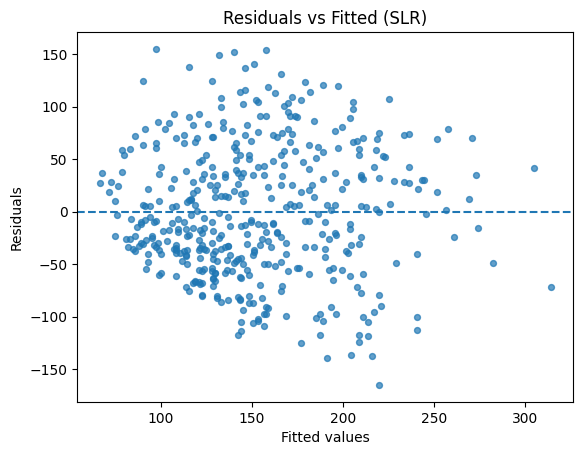

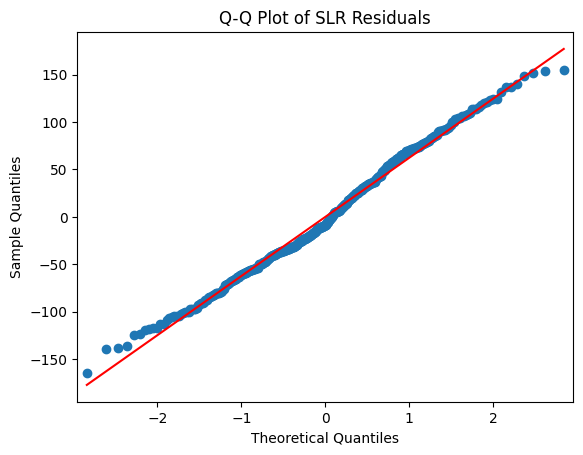

Top 10 influential points (SLR)


,cooks_distance,leverage
0,0.025992,0.007360
1,0.022201,0.031352
2,0.018009,0.010903
3,0.017441,0.005620
4,0.016661,0.006763
5,0.014368,0.010903
6,0.013066,0.006551
7,0.012813,0.005313
8,0.012139,0.008158
9,0.011847,0.006478


Heteroskedasticity test (SLR)


,Breusch-Pagan p-value
0,0.000853


In [16]:
# === Residual diagnostics & influence ===
# Residuals from SLR
resid_slr = y_arr - y_hat_slr

# Residuals vs Fitted: check nonlinearity/heteroskedasticity
plt.figure()
plt.scatter(y_hat_slr, resid_slr, s=18, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (SLR)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# QQ plot: residual normality (line='s' uses standardized line)
fig = qqplot(resid_slr, line='s')
plt.title("Q-Q Plot of SLR Residuals")
plt.show()

# Breusch–Pagan test for heteroskedasticity
bp_stat, bp_pval, _, _ = het_breuschpagan(resid_slr, X_sm)

# Influence measures: Cook's distance & leverage
infl = ols.get_influence()
cooks = infl.cooks_distance[0]
leverage = infl.hat_matrix_diag

diag = pd.DataFrame({
    "cooks_distance": cooks,
    "leverage": leverage
}).sort_values("cooks_distance", ascending=False).head(10)

display_dataframe_to_user("Top 10 influential points (SLR)", diag.reset_index(drop=True))

# Add BP p-value to a small table
test_table = pd.DataFrame({"Breusch-Pagan p-value": [bp_pval]})
display_dataframe_to_user("Heteroskedasticity test (SLR)", test_table)


Polynomial degree selection (10-fold CV)


,poly_degree,CV_RMSE
0,1,62.604289
1,2,62.799326
2,3,62.989974
3,4,63.332757
4,5,62.911145


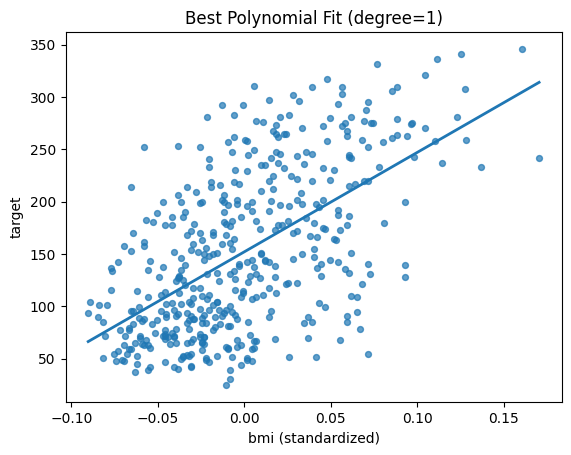

In [17]:
# === Polynomial regression on BMI with CV degree selection ===
def cv_rmse_for_degree(d):
    """10-fold CV RMSE for polynomial degree d (bmi only)."""
    model = make_pipeline(PolynomialFeatures(d, include_bias=False),
                          LinearRegression())
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse = -cross_val_score(model, X_bmi, y_arr,
                            scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                            cv=cv).mean()
    return rmse

degrees = list(range(1, 6))
rmse_by_degree = [(d, cv_rmse_for_degree(d)) for d in degrees]
tab_poly = pd.DataFrame(rmse_by_degree, columns=["poly_degree", "CV_RMSE"])
best_degree = int(tab_poly.sort_values("CV_RMSE").iloc[0]["poly_degree"])

display_dataframe_to_user("Polynomial degree selection (10-fold CV)", tab_poly)

# Fit best polynomial and plot
poly_model = make_pipeline(PolynomialFeatures(best_degree, include_bias=False),
                           LinearRegression()).fit(X_bmi, y_arr)
yy_poly = poly_model.predict(xx)

plt.figure()
plt.scatter(df["bmi"], y_arr, s=18, alpha=0.7)
plt.plot(xx, yy_poly, linewidth=2)
plt.title(f"Best Polynomial Fit (degree={best_degree})")
plt.xlabel("bmi (standardized)")
plt.ylabel("target")
plt.show()


In [18]:
# === Multiple regression with robust SE (statsmodels) ===
# Build full design matrix with intercept
X_full = sm.add_constant(df.drop(columns=["target"]).values)

# Fit OLS and robust version
ols_full = sm.OLS(y_arr, X_full).fit()
ols_full_robust = ols_full.get_robustcov_results(cov_type="HC3")

# Extract partial effect of BMI: its coefficient and robust SE
bmi_index = list(df.drop(columns=["target"]).columns).index("bmi") + 1  # +1 for intercept at col 0
bmi_coef = ols_full.params[bmi_index]
bmi_se_robust = ols_full_robust.bse[bmi_index]

multi_summary = pd.DataFrame({
    "term": ["bmi (partial)"],
    "coef": [bmi_coef],
    "robust_se(HC3)": [bmi_se_robust],
    "t_value": [bmi_coef / bmi_se_robust]
})
display_dataframe_to_user("Multiple regression (partial BMI effect) with robust SE", multi_summary)


Multiple regression (partial BMI effect) with robust SE


,term,coef,robust_se(HC3),t_value
0,bmi (partial),519.84592,68.590769,7.578949


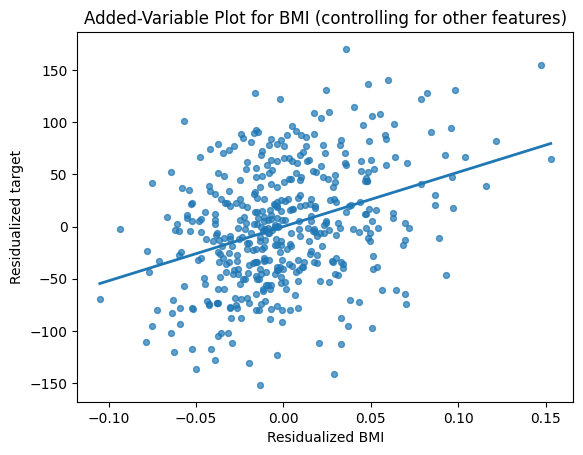

In [19]:
# === Added-variable (partial regression) plot for BMI ===
# Residualize target on controls (all except bmi), and bmi on the same controls
X_controls = df.drop(columns=["target", "bmi"]).values
Xc = sm.add_constant(X_controls)
res_y = sm.OLS(y_arr, Xc).fit().resid
res_bmi = sm.OLS(df["bmi"].values, Xc).fit().resid

# Plot residualized BMI vs residualized target
plt.figure()
plt.scatter(res_bmi, res_y, s=18, alpha=0.7)
coef_partial = np.polyfit(res_bmi, res_y, 1)
line_x = np.linspace(res_bmi.min(), res_bmi.max(), 300)
plt.plot(line_x, np.polyval(coef_partial, line_x), linewidth=2)
plt.title("Added-Variable Plot for BMI (controlling for other features)")
plt.xlabel("Residualized BMI")
plt.ylabel("Residualized target")
plt.show()


In [20]:
# === Regularization (Ridge & Lasso) vs OLS coefficients ===
# Ridge: log-spaced alphas; Lasso: internal path search with 10-fold CV
alphas = np.geomspace(1e-3, 1e3, 100)

X_all = df.drop(columns=["target"]).values
ridge = RidgeCV(alphas=alphas, store_cv_values=False).fit(X_all, y_arr)
lasso = LassoCV(alphas=None, cv=10, random_state=42, n_alphas=100).fit(X_all, y_arr)

coef_table = pd.DataFrame({
    "feature": df.drop(columns=["target"]).columns,
    "OLS_full": ols_full.params[1:],  # skip intercept
    "Ridge": ridge.coef_,
    "Lasso": lasso.coef_
}).sort_values("OLS_full", key=lambda s: s.abs(), ascending=False)

display_dataframe_to_user("Coefficient comparison: OLS vs Ridge vs Lasso", coef_table.reset_index(drop=True))

# Extract BMI row for quick comparison
bmi_row = coef_table.loc[coef_table["feature"]=="bmi"]
display_dataframe_to_user("BMI coefficient across models", bmi_row.reset_index(drop=True))


Coefficient comparison: OLS vs Ridge vs Lasso


,feature,OLS_full,Ridge,Lasso
0,s1,-792.175639,-547.475235,-92.831552
1,s5,751.273700,657.788378,508.078335
2,bmi,519.845920,521.056930,521.172424
3,s2,476.739021,282.626597,-0.000000
4,bp,324.384646,322.467922,292.377164
5,sex,-239.815644,-237.277928,-188.585504
6,s4,177.063238,148.328962,0.000000
7,s3,101.043268,-6.507128,-220.945511
8,s6,67.626692,69.341322,50.210204
9,age,-10.009866,-8.509261,-0.000000


BMI coefficient across models


,feature,OLS_full,Ridge,Lasso
0,bmi,519.84592,521.05693,521.172424


In [21]:
# === Model comparison by 10-fold CV RMSE ===
def cv_rmse_estimator(model, X, y, n_splits=10):
    """Compute mean CV RMSE for a given model and data."""
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    return -cross_val_score(model, X, y,
                            scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                            cv=cv).mean()

# Define comparable pipelines/specs
model_slr = LinearRegression()
model_poly_best = make_pipeline(PolynomialFeatures(best_degree, include_bias=False),
                                LinearRegression())
model_full = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                           LinearRegression())
model_ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
model_lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, random_state=42))

# Evaluate CV RMSE
cv_results = []
cv_results.append(("SLR (BMI only)", cv_rmse_estimator(model_slr, X_bmi, y_arr)))
cv_results.append((f"Polynomial BMI (deg={best_degree})", cv_rmse_estimator(model_poly_best, X_bmi, y_arr)))
cv_results.append(("Full OLS (all features)", cv_rmse_estimator(model_full, X_all, y_arr)))
cv_results.append(("Ridge (all features)", cv_rmse_estimator(model_ridge, X_all, y_arr)))
cv_results.append(("Lasso (all features)", cv_rmse_estimator(model_lasso, X_all, y_arr)))

cv_table = pd.DataFrame(cv_results, columns=["model", "CV_RMSE"]).sort_values("CV_RMSE")
display_dataframe_to_user("Model comparison (10-fold CV RMSE)", cv_table.reset_index(drop=True))


Model comparison (10-fold CV RMSE)


,model,CV_RMSE
0,Lasso (all features),54.837533
1,Full OLS (all features),54.860615
2,Ridge (all features),55.042534
3,SLR (BMI only),62.604289
4,Polynomial BMI (deg=1),62.604289
